In [ ]:
!pip install numpy
!pip install maths
!pip install pandas
!pip install matplotlib

!pip install tensorflow
!pip install sklearn


In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
df_given = pd.read_csv('Shop_dataset.csv')


In [102]:
df_list = []
df_df = []
item_titles = ['shop1_item1','shop1_item2','shop1_item3','shop1_item4','shop1_item4','shop2_item1','shop2_item2','shop2_item3','shop2_item4','shop2_item5'] 
for ele in item_titles:
  df_ele = df_given[ele]
  df_original = df_given.filter([ele], axis=1)
  df_list.append(df_ele)
  df_df.append(df_original)


In [104]:
scaler = MinMaxScaler((0,1))



In [105]:
#To plit given data into train and split
Train_Test_data = []
for ele in df_list:
  ele = scaler.fit_transform(np.array(ele).reshape(-1,1))
  training_size =int(len(ele)*0.90)
  test_size = len(ele) - training_size
  train_data,test_data = ele[0:training_size,:],ele[training_size:len(ele),:1]
  #To scale the data between the range of 0,1

  Train_Test_data.append([train_data,test_data])

In [106]:
def create_df(df, time_step=1):
	X, Y = [], []
	for i in range(len(df)-time_step-1):
		a = df[i:(i+time_step), 0]  
		X.append(a)
		Y.append(df[i + time_step, 0])
	return np.array(X), np.array(Y)

In [107]:
Train_Test_LSTM_structure = []
time_step = 100
for ele in Train_Test_data:
  X_train, y_train = create_df(ele[0], time_step)
  X_test, y_test = create_df(ele[1], time_step)
  # reshape input to be [samples, time steps, features]
  X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

  Train_Test_LSTM_structure.append([X_train,y_train,X_test,y_test])

In [109]:
model=Sequential()
model.add(LSTM(50,activation=keras.layers.LeakyReLU(alpha=0.01), return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [110]:
Train_Test_LSTM_structure_notif_val = 1
model_list = []
for ele in Train_Test_LSTM_structure:
  X_train,y_train,X_test,y_test = ele
  print('----------------------------------------------------------------')
  print('currently calculating for '+ str(Train_Test_LSTM_structure_notif_val) )
  print('----------------------------------------------------------------')
  model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=50,verbose=1)

  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  model_list.append([train_predict,test_predict])
  Train_Test_LSTM_structure_notif_val +=1

----------------------------------------------------------------
currently calculating for 1
----------------------------------------------------------------
Epoch 1/2
88/88 [==============================] - 17s 155ms/step - loss: 5.4721e-04 - val_loss: 0.0015
Epoch 2/2
88/88 [==============================] - 13s 146ms/step - loss: 6.1284e-06 - val_loss: 0.0014
----------------------------------------------------------------
currently calculating for 2
----------------------------------------------------------------
Epoch 1/2
88/88 [==============================] - 13s 147ms/step - loss: 2.5810e-04 - val_loss: 1.3611e-04
Epoch 2/2
88/88 [==============================] - 13s 149ms/step - loss: 2.5149e-04 - val_loss: 1.2144e-04
----------------------------------------------------------------
currently calculating for 3
----------------------------------------------------------------
Epoch 1/2
88/88 [==============================] - 13s 151ms/step - loss: 0.0019 - val_loss: 0.0086
Ep

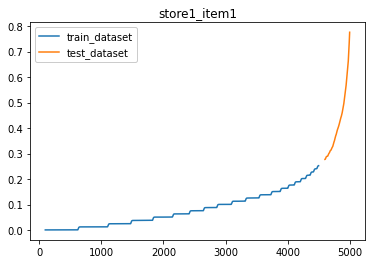

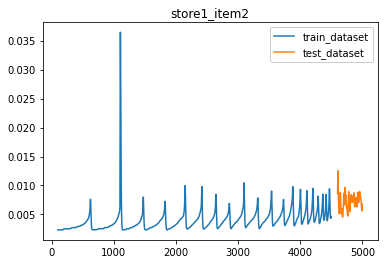

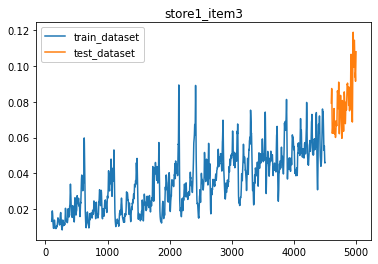

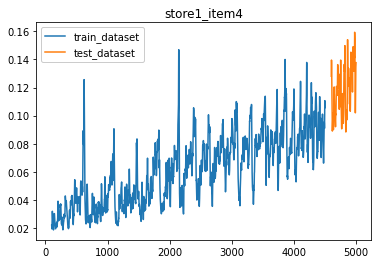

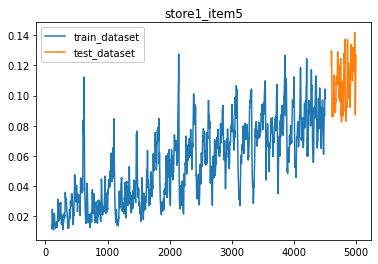

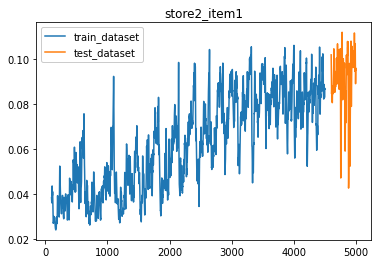

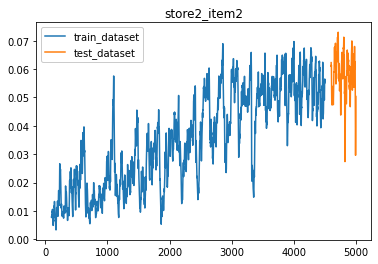

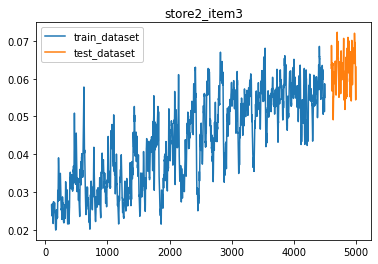

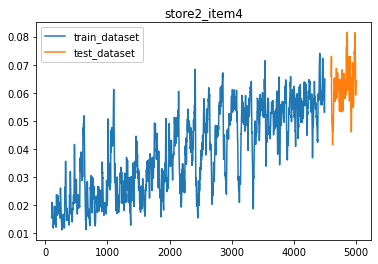

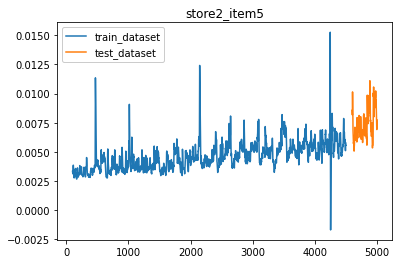

In [134]:
# To plot train vs test dataset
for ele in range(len(model_list)):
  trainPlot = np.empty_like(df_df[ele])
  trainPlot[:,:] = np.nan
  testPlot = np.empty_like(df_df[ele])
  testPlot[:, :] = np.nan
  previous=100
  trainPlot[previous:len(model_list[ele][0])+previous, :] = model_list[ele][0]
  testPlot[len(model_list[ele][0])+(previous*2)+1:len(df_df[ele])-1, :] = model_list[ele][1]
  plt.plot(trainPlot,label = "train_dataset")
  plt.plot(testPlot,label = "test_dataset")
  if ele <= 4:
    plt.title("store1_item"+str(ele+1))
  else:
    plt.title("store2_item"+str(ele-4))
  plt.legend(framealpha=1, frameon=True)

  plt.show()
  
  

In [135]:
#Future predicted values for the next 10
FINAL_VALUE = []

for ele in range(10):


  test_data = np.array(df_list[ele])
  x_input=test_data[-100:].reshape(1,-1)


  temp_input=x_input #list(x_input)
  temp_input=temp_input[0].tolist()


  lst_output=[]
  n_steps=100
  i=0
  while(i<10):
      
      if(len(temp_input)>100):
        
          x_input=np.array(temp_input[1:])
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))   
          ycap = model.predict(x_input, verbose=0)
          temp_input.extend(ycap[0].tolist())
          temp_input=temp_input[1:]  
          lst_output.extend(ycap.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          ycap = model.predict(x_input, verbose=0)
          print(ycap[0])
          temp_input.extend(ycap[0].tolist())
          lst_output.extend(ycap.tolist())
          i=i+1

          FINAL_VALUE.append(lst_output)


[-0.2836009]
[-0.12077389]
[-0.3610257]
[-0.40815902]
[-0.40815902]
[-0.35021174]
[-0.42541653]
[-0.39253083]
[-0.36303085]
[-0.36647743]


In [136]:
#Future predicted values Scaled
FINAL_VALUE_SCALED = []
for i in range(10):
  x = []
  ele = np.array(df_df[i])
  for j in range(10):
        a = (((ele.max() - ele.min())*FINAL_VALUE[i][j][0]) - ele.min())
        x.append(round(abs(a)))
  FINAL_VALUE_SCALED.append(x)
print(FINAL_VALUE_SCALED)

[[24, 29, 31, 39, 26, 28, 37, 37, 26, 35], [243, 485, 893, 724, 997, 711, 786, 861, 741, 850], [74, 71, 82, 73, 77, 91, 80, 78, 79, 73], [59, 66, 46, 55, 63, 62, 65, 40, 57, 64], [59, 66, 46, 55, 63, 62, 65, 40, 57, 64], [54, 42, 55, 36, 76, 68, 58, 70, 68, 64], [88, 86, 76, 88, 107, 75, 59, 89, 86, 114], [83, 80, 76, 74, 80, 82, 79, 78, 91, 92], [73, 76, 55, 105, 108, 108, 57, 76, 141, 117], [739, 777, 883, 779, 1164, 774, 927, 1026, 956, 1190]]


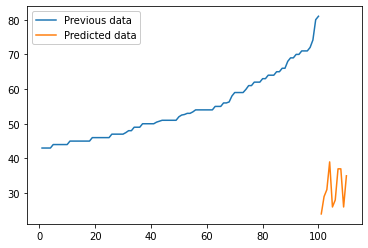

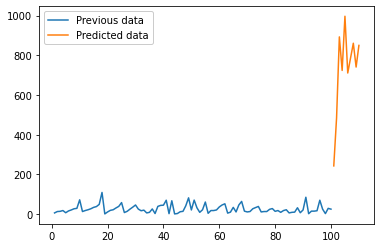

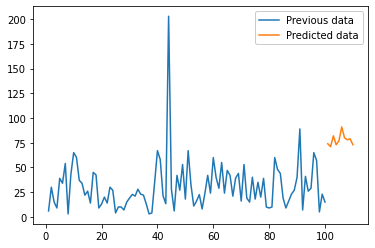

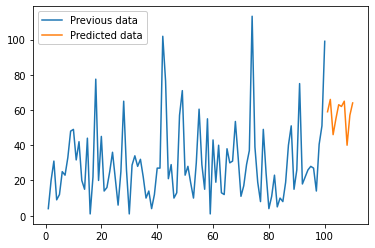

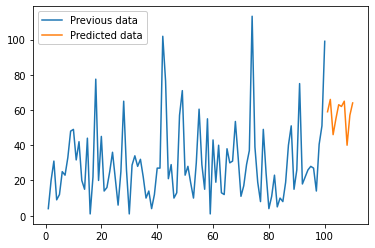

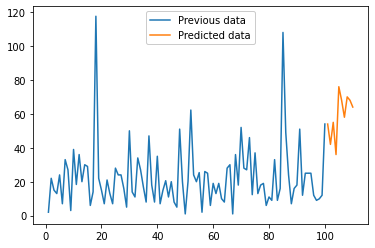

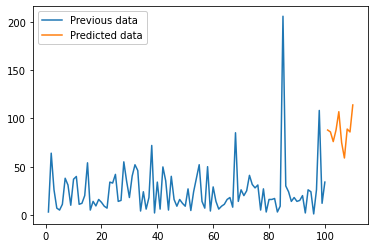

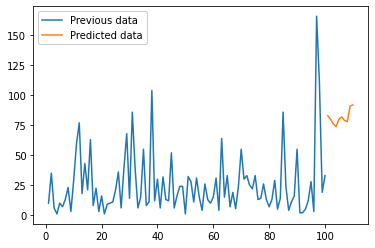

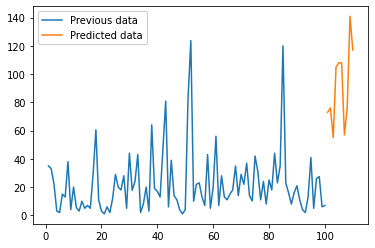

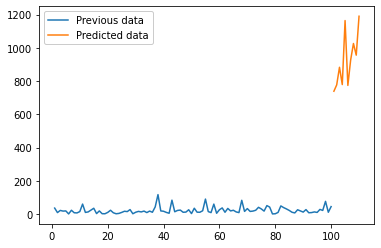

In [137]:
#Graph for predicted data
for ele in range(10):

  max_val_day_pred = len(FINAL_VALUE_SCALED[ele])+1
  day_new=np.arange(1,101)
  day_pred=np.arange(101,111)

  min_val_df = len(df_list[ele])-100
  plt.plot(day_new,df_df[ele][min_val_df:],label = "Previous data")
  plt.plot(day_pred,FINAL_VALUE_SCALED[ele],label = "Predicted data")
  plt.legend(framealpha=1, frameon=True)
  plt.show()